# DATASCI W261: Machine Learning at Scale
## Assignment Week 5
Jackson Lane (jelane@berkeley.edu) <br>
W261-3 <br>


# === Week 5 ASSIGNMENTS ===

## HW 5.0
#### What is a data warehouse? 
A data warehouse is repository storing structured data used for reporting and analytics.  It's kind of like a database that is used for analytics instead of transactions (OLAP vs OLTP).  Often a data warehouse pulls data or is built on top of one or more other databases or data warehouses.  However, data warehouses are structured, so they have to extract and transform data prior to storing it.  The benefit of this is that users do not need to deal with the different naming conventions and data models of the backend systems and instead can write queries against one universal semantic view.  

#### What is a Star schema? When is it used?

## HW 5.1
#### In the database world What is 3NF? 

Does machine learning use data in 3NF? If so why? 

#### In what form does ML consume data?
Why would one use log files that are denormalized?


## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)
:

#### Justify which table you chose as the Left table in this hashside join.

I chose the URLs table as the left table, as it's smaller than the Visits table.  Although, not byy much, as wh

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right

(2) Right joining Table Left with Table Right

(3) Inner joining Table Left with Table Right

--

In [301]:
%%writefile MRJob5_2.py
#!/usr/bin/python
from mrjob.job import MRJob, MRStep
import re

class MRJob5_2(MRJob):
    

    def steps(self):
        return [MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper, 
                mapper_final = self.mapper_final, jobconf={
                 'mapreduce.job.maps': '1'
                          })]
        
    def mapper_init(self):
        self.urls = {}
        self.pages = []
        self.all = 0
        self.rightonly = 0
        self.leftonly = 0
        with open("urls.data") as urls:
            for line in urls.readlines():
                fields = line.strip().split(",")
                self.urls[fields[1]] = "www.microsoft.com" + fields[4].strip().strip('"') 

    
    def mapper(self, _, line):
        line = line.strip()
        line = line.split(",")
        webpageID = line[1]
        visitorID = line[4]
        self.pages.append(webpageID)
        if webpageID in self.urls.keys():
            self.all += 1
            yield "inner",self.urls[webpageID]+","+webpageID+","+visitorID
            yield "left",self.urls[webpageID]+","+webpageID+","+visitorID
            yield "right",self.urls[webpageID]+","+webpageID+","+visitorID
        else:
            self.rightonly += 1
            yield "right","None,"+webpageID+","+visitorID
            
    def mapper_final(self):
        #Let's now check if there are any pages that never got any visitors, meaning that only a left join is possible
        for webpageID in self.urls.keys():
            if webpageID not in self.pages:
                self.leftonly += 1
                yield "left", self.urls[webpageID]+","+webpageID+",None"
        yield "Number of Possible Left Joins",str(self.all + self.leftonly)
        yield "Number of Possible Inner Joins", str(self.all)
        yield "Number of Possible Right Joins",str(self.all + self.rightonly)

if __name__ == '__main__':
    MRJob5_2.run()

Overwriting MRJob5_2.py


Driver Class

In [55]:
%reload_ext autoreload
%autoreload 2

from MRJob5_2 import MRJob5_2
mr_job = MRJob5_2(args=['Processed-anonymous-msweb.data','-r','hadoop','--file',"urls.data",'--cleanup'])
with mr_job.make_runner() as runner:
    runner.run()
    output = open("output.txt","w")
    for line in runner.stream_output():
        output.write(line)
    output.close()
!tail -10 output.txt

"left"	"www.microsoft.com/devmovies,1290,None"
"left"	"www.microsoft.com/news,1291,None"
"left"	"www.microsoft.com/centroam,1297,None"
"left"	"www.microsoft.com/bookshelf,1294,None"
"left"	"www.microsoft.com/autoroute,1287,None"
"left"	"www.microsoft.com/masterchef,1289,None"
"left"	"www.microsoft.com/library,1288,None"
"Number of Left Joins"	"98663"
"Number of Inner Joins"	"98654"
"Number of Right Joins"	"98654"


## HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

   https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

   s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

In [333]:
%%writefile MRJob5_3.py
#!/usr/bin/python
#
# This job will read a a series of NGrams and produce the following summmary statistics
# Longest NGram
# Top 10 most frequent words
# 20 most densley appearing words
# 20 least densley appearing words
# Distribution of NGram sizes (character count)
# This job computes these summary statistics across 5 different partitions one for each summary statistic
# The reducer code is set to behave differently depending on which partition it is in
# Overall running time for me was several hours ,
# most likely due to the fact that the first step in this job emits each line of text 
# 5 times (once for each word in the 5 gram)/

import sys
from mrjob.job import MRJob, MRStep
from mrjob.protocol import RawProtocol

class MRJob5_3(MRJob):
    
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol

    def steps(self):
        return [MRStep(mapper = self.mapper_wordcount, combiner = self.combiner_wordcount, reducer = self.reducer_wordcount),
               MRStep(mapper = self.mapper_process, reducer = self.reducer_process, jobconf={
                                        'mapreduce.job.maps': '8',
                    'mapreduce.job.reduces': '4',
                            }),
                MRStep(reducer_init = self.reducer_sortreport_init, reducer = self.reducer_sortreport, 
                jobconf={
                    'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                    'stream.num.map.output.key.field': 3,
                    'stream.map.output.field.separator':'\t',
                    'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2n',
                          })]         
                      
    def mapper_wordcount(self, _, line):
            line = line.strip()
            [ngram,count,pages_count,books_count] = line.split("\t")
            count = int(count)
            pages_count = int(pages_count)
            books_count = int(books_count)
            words = ngram.split()
            for word in words:
                yield ngram+","+word, str([count,pages_count,books_count])

    def combiner_wordcount(self, key, counts):
        newcount =0
        for line in counts: 
            [count,pages_count,books_count] =eval(line)
            newcount += count
        yield key,str([newcount,pages_count,books_count])

    def reducer_wordcount(self, key, counts):
        newcount =0
        for line in counts:
            [count,pages_count,books_count] =eval(line)
            newcount += count
        yield key,str([newcount,pages_count,books_count] )
            
    def mapper_process  (self,key,counts):
        ngram, word = key.split(",")
        words_in_ngram = len(ngram.split())
        [count,pages_count,books_count] = eval(counts)
        yield "A: Longest 5-gram\t1", ngram
        yield "B: Top 10 most frequent words," + word+"\t1",str(count)
        yield "C: 20 Most/Least densely appearing words," + word+"\t1",str([count,pages_count])
        yield "D: Distribution of 5-gram sizes," + str( len(ngram))+"\t1",str(float(count) / words_in_ngram)
    
    def reducer_process(self,key,values):
        keyfields = key.split(",")
        goal = keyfields[0]
        values = map(lambda v: v.split("\t")[1], values)

        if goal == "A: Longest 5-gram":
            ngrams = values
            for ngram in ngrams:
                yield goal, str(-1*len(ngram))+"\t"+ngram
        elif goal == "B: Top 10 most frequent words":
            word = keyfields[1]
            yield goal,str(-1*sum(map(int,values)))+"\t"+word
        elif goal == "C: 20 Most/Least densely appearing words" :
            word = keyfields[1]
            count =0
            pages_count = 0
            for line in values:
                [c,p] = eval(line)
                count+= c
                pages_count+=p
            yield "C: 20 least densely appearing words",str(sum([(float(1)*count)/ pages_count]))+"\t"+word
            yield "C: 20 most densely appearing words",str(sum([(float(-1)*count)/ pages_count]))+"\t"+word
        else:
            gram_length = keyfields[1]
            yield "D: Distribution of 5-gram sizes",str(sum(map(float,values)))+"\t"+gram_length
            
    def reducer_sortreport_init(self):
        self.goal_report_limits = {
            "A: Longest 5-gram": 1,
            "B: Top 10 most frequent words": 10,
            "C: 20 least densely appearing words": 20,
            "C: 20 most densely appearing words": 20,
            "D: Distribution of 5-gram sizes": -1
        }
    
    def reducer_sortreport(self,goal,lines):
        yield "--------","--------"
        yield goal, ":"
        for line in lines:
            if self.goal_report_limits[goal] == 0: break
            self.goal_report_limits[goal] = self.goal_report_limits[goal] -1
            line = line.strip()
            number_field,category_field = line.split("\t")
            number_field = float(number_field)
            if number_field < 0: number_field *= -1
            yield category_field, str(number_field)

if __name__ == '__main__':
    MRJob5_3.run()

Overwriting MRJob5_3.py


Unit Test

In [334]:
!head -n 10 filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt > unitTestData

In [339]:
!hdfs dfs -rm -r results/5.3/UnitTest
!python MRJob5_3.py unitTestData -r hadoop --output-dir ./results/5.3/UnitTest \
--cleanup=ALL 2>/dev/null >NGramsEDAUnitTest

16/06/19 15:11:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/19 15:12:00 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/5.3/UnitTest


--------	--------
A: Longest 5-gram	:
A Circumstantial Narrative of the	33.0
--------	--------
B: Top 10 most frequent words	:
A	2217.0
in	1201.0
Christmas	1099.0
Wales	1099.0
Child's	1099.0
of	1011.0
Study	604.0
Case	604.0
Female	447.0
Collection	239.0
--------	--------
C: 20 least densely appearing words	:
Female	1.0
Case	1.0
Limited	1.0
Narrative	1.0
ESTABLISHING	1.0
RELIGIOUS	1.0
Government	1.0
Circumstantial	1.0
FOR	1.0
Study	1.0
BILL	1.0
the	1.01639344262
George	1.02222222222
General	1.02222222222
Biography	1.02222222222
A	1.02829313544
in	1.03267411866
Sea	1.03333333333
City	1.03333333333
by	1.03333333333
--------	--------
C: 20 most densely appearing words	:
of	1.15675057208
Forms	1.12621359223
Collection	1.08636363636
Fairy	1.05128205128
Tales	1.05128205128
Child's	1.03581526861
Wales	1.03581526861
Christmas	1.03581526861
by	1.03333333333
City	1.03333333333
Sea	1.03333333333
in	1.03267411866
A	1.02829313544
George	1.02222222222
Biography	1.02222222222
General	1.02222222222
the

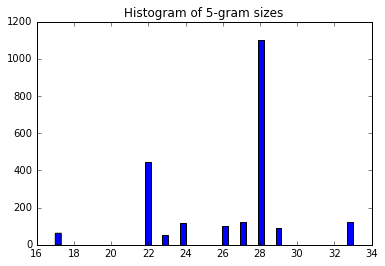

In [343]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
distribution = {}
with open("NGramsEDAUnitTest") as myfile:
    partD = False
    for line in myfile.readlines():
        line = line.strip().replace('"','')
        line =  line.split("\t")
        if (line[0] == "D: Distribution of 5-gram sizes"):
            partD = True
            continue
        if partD:
            distribution[int(line[0])] = float(line[1])
        else: print '\t'.join(map(str,line))

plt.hist(distribution.keys(), weights=distribution.values(), bins=50)
plt.title("Histogram of 5-gram sizes")
plt.show()

Run the job on the full dataset:

In [345]:
!hdfs dfs -rm -r results/5.3
!python MRJob5_3.py filtered-5Grams -r hadoop --output-dir ./results/5.3 \
--cleanup=ALL 2>/dev/null >NGramsEDA

16/06/19 15:29:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/19 15:29:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/5.3


--------	--------
A: Longest 5-gram	:
AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR	160.0
--------	--------
B: Top 10 most frequent words	:
the	5375699242.0
of	3691308874.0
to	2221164346.0
in	1387638591.0
a	1342195425.0
and	1135779433.0
that	798553959.0
is	756296656.0
be	688053106.0
as	481373389.0
--------	--------
C: 20 least densely appearing words	:
Leshchetitsky	1.0
Leshkowich	1.0
Nescit	1.0
Leskov	1.0
Nescio	1.0
Leslea	1.0
Nescience	1.0
Nescia	1.0
Lesley's	1.0
Nescafe	1.0
Leslies	1.0
Nesbitt	1.0
Lesly	1.0
Nesbit's	1.0
Lesly's	1.0
Nesace	1.0
Lesmahago	1.0
Lespinasse	1.0
Lespenard	1.0
AAAA	1.0
--------	--------
C: 20 most densely appearing words	:
xxxx	11.557291666666666
NA	10.161726044782885
blah	8.0741599073001158
nnn	7.5333333333333332
nd	6.5611436445056839
ND	5.4073642846747196
oooooooooooooooo	4.921875
PIC	4.7272727272727275
llll	4.5116279069767442
LUTHER	4.34949832

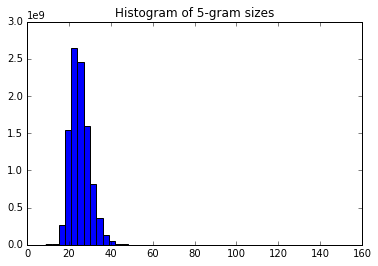

In [346]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
distribution = {}
with open("NGramsEDA") as myfile:
    partD = False
    for line in myfile.readlines():
        line = line.strip().replace('"','')
        line =  line.split("\t")
        if (line[0] == "D: Distribution of 5-gram sizes"):
            partD = True
            continue
        if partD:
            distribution[int(line[0])] = float(line[1])
        else: print '\t'.join(map(str,line))

plt.hist(distribution.keys(), weights=distribution.values(), bins=50)
plt.title("Histogram of 5-gram sizes")
plt.show()

HW 5.3.1 OPTIONAL Question:
- Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
https://en.wikipedia.org/wiki/Power_law
--

## HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

DocA {X:20, Y:30, Z:5}
DocB {X:100, Y:20}
DocC {M:5, N:20, Z:5}


### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

In [388]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")

with open("stopwords","w") as myfile:
    myfile.write(str(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Since the stopwords from seem to all be in lowercase, I'll the ngram words to lowercase as well before checking whether they exist in the stopwords list.  

In [392]:
%%writefile MRJob5_4_wordcount.py
from mrjob.job import MRJob, MRStep
from mrjob.protocol import RawProtocol

class MRJob5_4_wordcount(MRJob):
    
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    SORT_VALUES = True

    def steps(self):
        return [MRStep(mapper_init=self.mapper_wordcount_init,mapper = self.mapper_wordcount, 
                       combiner = self.reducer_wordcount, reducer = self.reducer_wordcount),
                MRStep(reducer = self.reducer_sortreport,
                jobconf={
               'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':'\t',
            'mapreduce.partition.keycomparator.options': '-k2,2nr -k1,1',

                          })]         
                      
    def mapper_wordcount_init(self):
            with open('stopwords') as myfile:
                self.stopwords = eval(myfile.readline())
                
    def mapper_wordcount(self, _, line):
            line = line.strip()
            [ngram,count,pages_count,books_count] = line.split("\t")
            words = ngram.split()
            for word in words:
                #Filter out the stop words
                if word.lower() not in self.stopwords:
                    yield word, count

    def reducer_wordcount(self, key, counts):
        yield key,str(sum(map(int,counts)))
        
    def reducer_sortreport(self,key,counts):
              yield key, counts.next()


if __name__ == '__main__':
    MRJob5_4_wordcount.run()

Overwriting MRJob5_4_wordcount.py


In [408]:
%reload_ext autoreload
%autoreload 2
!hdfs dfs -rm -r results/5.4/wordcount

from MRJob5_4_wordcount import MRJob5_4_wordcount
mr_job = MRJob5_4_wordcount(args=['filtered-5Grams','-r','hadoop',
                                  '--file','stopwords','--output-dir','./results/5.4/wordcount','--cleanup','ALL'])
with mr_job.make_runner() as runner:
    runner.run()
    output = open("topwords.txt","w")
    for line in runner.stream_output():
        output.write(line)
    output.close()

16/06/19 18:05:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `results/5.4/wordcount': No such file or directory


In [842]:
%%writefile MRJob5_4_cooccurence.py

from mrjob.job import MRJob, MRStep
import sys

class MRJob5_4_cooccurence(MRJob):
    
    MRJob.SORT_VALUES = True 
    def steps(self):
           return [  MRStep(mapper_init=self.mapper_coocurrence_init, mapper=self.mapper_coocurrence
                        , combiner=self.combiner_coocurrence, reducer_init=self.reducer_coocurrence_init
                        , reducer=self.reducer_coocurrence, reducer_final=self.reducer_coocurrence_final
                        , jobconf={
                        'mapreduce.job.reduces': '4', 
                    } 
                      ),
                       MRStep(reducer = self.reducer_merge)
                  ]
    

    def mapper_coocurrence_init(self):
        with open("topwords.txt") as myfile:
            vocab = []
            for i in range(10000):
                line = myfile.readline().strip()
                word, count = line.split("\t")
                vocab.append(word.strip())
            self.top10k = set(vocab[:10001])
            self.basis =  set(vocab[9001:10001])
        
      
    def mapper_coocurrence(self, _, line):
        # parse line, get words and counts
        ngram, count, _, _ = line.strip().split('\t')
        words = ngram.split()
        words = sorted(list(set(filter(lambda w: w in self.top10k,words))))
        # emit each pair of words
        for word1 in words:
            for word2 in words:
                if word2 in self.basis and word2 <> word1:
                    yield [word1,word2],int(count)

    def combiner_coocurrence(self, words, counts):
        yield words, sum(map(int,counts))
    
    def reducer_coocurrence_init(self):
        self.word = '*'
        self.stripe = {}
                        
    def reducer_coocurrence(self, words, counts):    
        newword1, newword2 = words    
        sys.stderr.write(str(words) + "\n")
        if self.word == newword1:
            self.stripe[newword2] =  self.stripe.setdefault(newword2,0)+ sum(counts)
        else:
            if len(self.stripe) > 0:
                yield self.word, self.stripe
            self.word = newword1
            self.stripe = {newword2:sum(counts)}
            

    def reducer_coocurrence_final(self):
        if len(self.stripe) > 0:
            yield self.word, self.stripe
    
        
    def reducer_merge(self,word,dicts):
        result = {}
        for d in dicts:
                for key,value in d.items():
                    result[key] = result.setdefault(key,0) + int(value)

        yield word, result

if __name__ == '__main__':
    MRJob5_4_cooccurence.run()

Overwriting MRJob5_4_cooccurence.py


In [856]:
%%writefile MRJob5_4_invert.py
from DebuggerProtocol import DebuggerProtocol

from mrjob.job import MRJob, MRStep
from mrjob.protocol import JSONProtocol

class MRJob5_4_invert(MRJob):
    
    MRJob.SORT_VALUES = True
    INTERNAL_PROTOCOL = DebuggerProtocol(JSONProtocol)
    def steps(self):
           return [  
                   MRStep( mapper=self.mapper_invert,reducer_init=self.reducer_invert_init
                    , reducer=self.reducer_invert
                    , jobconf={
                    'mapreduce.job.reduces': 4,
                    } 
                      )
                  ]
    

    def mapper_invert(self, _, line):
        word1, stripe = line.split("\t")
        stripe = eval(stripe)
        yield word1,('*',len(stripe))
        for word2,count in stripe.items():
                    yield word2, (word1+'.'+str(len(stripe)),count)
                        
    def reducer_invert_init(self):
        self.length = 0
        self.stripe={}
        
    def reducer_invert(self,word1, word_counts):
        for (word2,count) in word_counts:
            word2 = str(word2)
            count = int(count)
            if(word2 == '*'):
                self.length = count
            else:
                self.stripe[word2] =  self.stripe.setdefault(word2,0)+ count
        if len(self.stripe) > 0:
            yield word1 +'.'+str(self.length), self.stripe
        
if __name__ == '__main__':
    MRJob5_4_invert.run()

Overwriting MRJob5_4_invert.py


(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

Jaccard similiarity 

In [843]:
%%writefile MRJob5_4_jaccard.py
from mrjob.job import MRJob
from mrjob.step import MRStep

import sys
class MRJob5_4_jaccard(MRJob):
    MRJob.SORT_VALUES = True 
    def steps(self):
        return [MRStep(mapper=self.mapper_jaccard , reducer=self.reducer_jaccard, jobconf= 
                        {           
            'mapreduce.job.reduces': '4',
                })
   
    def mapper_jaccard(self, _, line):
        word0, stripe = line.split("\t")
        stripe = eval(stripe).keys()
        for i,word1 in enumerate(stripe):
            for word2 in stripe[i+1:]:
                yield (word1,word2), 1
        
    def reducer_jaccard(self,words,counts):
        word1,word2 = map(str,words)
        word1, length1 = word1.split(".")
        word2,length2 = word2.split(".")
        intersection = sum(map(float,counts))
        jaccard = intersection / (int(length1) + int(length2) - intersection)
        yield (word1,word2), jaccard
            
if __name__ == '__main__':
    MRJob5_4_jaccard.run()



Overwriting MRJob5_4_jaccard.py


In [862]:
%%writefile MRJob5_4_cosine.py

from mrjob.job import MRJob, MRStep
import sys

class MRJob5_4_cosine(MRJob):
    MRJob.SORT_VALUES = True 

    def steps(self):
        return [
            #The first step calculates the inverted index and normalizes
            MRStep(
                mapper=self.mapper_inverted
                ,combiner=self.combiner_inverted
                ,reducer=self.reducer_inverted,
                jobconf= 
                        {           
            'mapreduce.job.reduces': '4',
                }) ,
            MRStep(
                mapper=self.mapper_cosine
                ,reducer=self.reducer_cosine,
                jobconf= 
                        {           
            'mapreduce.partition.keycomparator.options': '-k2',            
            'mapreduce.job.reduces': '4',
                })
                  
        ]
    
    def mapper_inverted(self, _, line):
        line = line.strip()
        word1, stripe=line.split('\t')
        stripe=eval(stripe)
        length = len(stripe)
        for (word2, count) in stripe.items():
            #Normalize length so that sum of squares is 1
            yield word2, {word1: 1/(float(length) ** .5)}

    def combiner_inverted(self, word, dicts):
        result = {}
        for d in dicts:
            result.update(d)
        yield word, result
        

    def reducer_inverted(self,word2,dicts):
        result={}
        for d in dicts:
            for (word1,count) in d.items():
                result[word1] = result.setdefault(word1,0)+int(count)
        yield word2, result

    def mapper_cosine(self,word,stripe):
        words=stripe.keys()     
        sys.stderr.write(str(words)+"\n")
        for i,word1 in enumerate(words[:-1]):
            for word2 in words[i+1:]:
                #Compute dot product
                yield (word1,word2),stripe.setdefault(word1,0)*stripe.setdefault(word2,0)
        
    def reducer_cosine(self,words,counts):
        yield words,sum(counts)
        
if __name__ == '__main__':
    MRJob5_4_cosine.run()

Overwriting MRJob5_4_cosine.py


First let's run the System Test:

In [854]:
%%writefile SystemTestData
DocA	{'X':20, 'Y':30, 'Z':5}
DocB	{'X':100, 'Y':20}
DocC	{'M':5, 'N':20, 'Z':5}

Overwriting SystemTestData


Since this data already appears to be indexed, we don't need to run the cooccurenceUnitTest job.  Instead, let's just get straight to the invertedindex job:  

In [857]:
!hdfs dfs -rm -r results/5.4/UnitTest/invertedIndex
!python MRJob5_4_invert.py SystemTestData -r hadoop --file DebuggerProtocol.py --output-dir ./results/5.4/UnitTest/invertedIndex \
--cleanup=ALL  2>/dev/null >invertedIndex
!head -25 invertedIndex

16/06/22 01:44:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/22 01:44:59 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/5.4/UnitTest/invertedIndex
"M.3"	{"DocC.3": 5}
"N.3"	{"DocC.3": 25}
"X.3"	{"DocA.3": 20, "DocC.3": 25}
"Y.0"	{"DocB.2": 20}
"Z.0"	{"DocB.2": 20, "DocA.3": 5}
"Y.3"	{"DocA.3": 30}
"X.0"	{"DocB.2": 100}
"Z.0"	{"DocB.2": 100, "DocC.3": 5}


Next run a unit test on the data from the Google Group:

In [858]:
%%writefile UnitTestData
advisory bedside	50	50	50
bedside Cathedral disciplines	10	10	10
advisory disciplines America	15	15	15
irrespective disciplines America	15	15	15
America AB	15	15	15

Overwriting UnitTestData


In [859]:
!hdfs dfs -rm -r results/5.4/UnitTest/co-occurence
!python MRJob5_4_cooccurence.py UnitTestData -r hadoop --file topwords.txt --output-dir ./results/5.4/UnitTest/co-occurence \
--cleanup=ALL  2>/dev/null >cooccurenceUnitTest
!head -25 cooccurenceUnitTest

16/06/22 01:45:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `results/5.4/UnitTest/co-occurence': No such file or directory
"America"	{"advisory": 15, "AB": 15, "disciplines": 30, "irrespective": 15}
"Cathedral"	{"bedside": 10, "disciplines": 10}
"advisory"	{"bedside": 50, "disciplines": 15}
"bedside"	{"Cathedral": 10, "disciplines": 10, "advisory": 50}
"disciplines"	{"Cathedral": 10, "bedside": 10, "advisory": 15, "irrespective": 15}
"irrespective"	{"disciplines": 15}


In [867]:
!hdfs dfs -rm -r results/5.4/UnitTest/invertedIndex
!python MRJob5_4_invert.py cooccurenceUnitTest -r hadoop --file DebuggerProtocol.py --output-dir ./results/5.4/UnitTest/invertedIndex \
--cleanup=ALL  2>/dev/null >invertedIndex
!head -25 invertedIndex

16/06/22 01:56:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `results/5.4/UnitTest/invertedIndex': No such file or directory
"Cathedral.0"	{"\"disciplines\".4": 10, "\"bedside\".3": 10}
"\"America\".4"	{"\"disciplines\".4": 10, "\"bedside\".3": 10}
"\"Cathedral\".2"	{"\"disciplines\".4": 10, "\"bedside\".3": 10}
"advisory.2"	{"\"disciplines\".4": 25, "\"bedside\".3": 10}
"bedside.2"	{"\"disciplines\".4": 35, "\"bedside\".3": 10}
"disciplines.2"	{"\"advisory\".2": 15, "\"disciplines\".4": 35, "\"bedside\".3": 10, "\"Cathedral\".2": 10}
"advisory.4"	{"\"bedside\".3": 50}
"disciplines.4"	{"\"irrespective\".1": 15, "\"bedside\".3": 60}
"irrespective.4"	{"\"America\".4": 15, "\"irrespective\".1": 15, "\"bedside\".3": 60}
"bedside.1"	{"\"advisory\".2": 50}
"disciplines.1"	{"\"America\".4": 30, "\"advisory\".2": 50}
"irrespective.1"	{"\"America\".4": 30, "\"advisory\".2": 50, "\"disciplines\".4": 15}
"A

In [851]:
!hdfs dfs -rm -r results/5.4/UnitTest/jaccard
!python MRJob5_4_jaccard.py in -r hadoop  --output-dir ./results/5.4/UnitTest/jaccard \
--cleanup=ALL 2>/dev/null | head -25

16/06/22 01:41:30 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/22 01:41:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/5.4/UnitTest/jaccard


In [861]:
!hdfs dfs -rm -r results/5.4/UnitTest/cosine
!python MRJob5_4_cosine.py cooccurenceUnitTest -r hadoop  --output-dir ./results/5.4/UnitTest/cosine \
--cleanup=ALL 2>/dev/null | head -25

16/06/22 01:51:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/22 01:51:14 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/5.4/UnitTest/cosine


Now run on NGram dataset

In [741]:
!hdfs dfs -rm -r results/5.4/co-occurence
!python MRJob5_4_cooccurence.py filtered-5Grams -r hadoop --file topwords.txt --output-dir ./results/5.4/co-occurence \
--cleanup=ALL 2> /dev/null > cooccurence
!head -3 cooccurence

16/06/21 20:29:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `results/5.4/co-occurence': No such file or directory
"AB"	{"wires": 51, "carriers": 53, "Nuclear": 53, "Price": 92, "diagonal": 58, "CD": 15062, "Oriental": 133, "segregation": 77, "lever": 77, "Fleet": 50, "Type": 48, "honors": 43}
"AD"	{"AB": 309, "Geography": 140, "Seventh": 166, "diagonal": 64, "CD": 53, "Peninsula": 343, "Buddhism": 70, "Towards": 78, "Documents": 95, "embassy": 42, "Trent": 52, "Throughout": 57, "HISTORY": 51}
"AIDS"	{"alveolar": 52, "Memorial": 50, "Task": 1152, "carriers": 245, "Nervous": 457, "Seventh": 620, "epidemic": 14055, "Practical": 92, "immunodeficiency": 257, "Swiss": 59, "abnormalities": 54, "degeneration": 73, "Changes": 55, "Geography": 118}


In [868]:
!hdfs dfs -rm -r results/5.4/jaccard
!python MRJob5_4_jaccard.py 'cooccurence'  -r hadoop --output-dir ./results/5.4/jaccard \
--cleanup=ALL 2>/null/dev > 'jaccard' 
!head -25 jaccard

16/06/22 01:57:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/22 01:57:44 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/5.4/jaccard
/bin/sh: /d: Permission denied


In [ ]:
!hdfs dfs -rm -r results/5.4/cosine
!python MRJob5_4_jaccard.py 'cooccurence'  -r hadoop --output-dir ./results/5.4/jaccard \
--cleanup=ALL 2>/dev/null > 'cosine' 
!head -25 cosine

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation
...

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

### HW 5.5 
Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in HW5.4, and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

In [385]:
#!/usr/bin/python2.7
''' pass a string to this funciton ( eg 'car') and it will give you a list of
words which is related to cat, called lemma of CAT. '''
import nltk
from nltk.corpus import wordnet as wn
import sys
import numpy as np
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

In [389]:
synonyms("AB")

[u'Bachelor_of_Arts',
 u'abdominal',
 u'BA',
 u'type_AB',
 u'AB',
 u'Artium_Baccalaurens',
 u'group_AB',
 u'Av',
 u'abdominal_muscle',
 u'ab',
 u'Ab']

HW5.6 Optional

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall



--

HW 5.7 (optional)
There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

>> from nltk.corpus import stopwords
>>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

HW 5.6 (optional)
There are many good ways to build our synonym detectors, so for optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.
--

Hw 5.7 (optional)
Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?

--

=====================
END OF ASSIGNMENT #5
=====================